In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
from sklearn import ensemble
from sklearn import datasets
from sklearn import tree
import os
import time
import datetime as dt
from functools import reduce

In [2]:
path_ts1 = "Datasets/TimerSeries1.csv"
path_ts2 = "Datasets/TimerSeries2.csv"

ts1 = pd.read_csv(path_ts1)
ts2 = pd.read_csv(path_ts2)

ts1.drop(["index"], axis=1, inplace=True)
ts2.drop(["level_0", "index"], axis=1, inplace=True)

ts1["DeliveryPeriod"] = pd.to_datetime(ts1["DeliveryPeriod"], format="%Y-%m-%d %H:%M:%S") + dt.timedelta(hours=1)
ts2["DeliveryPeriod"] = pd.to_datetime(ts2["DeliveryPeriod"], format="%Y-%m-%d %H:%M:%S") + dt.timedelta(hours=1)

ts1.set_index("DeliveryPeriod", inplace=True)
ts2.set_index("DeliveryPeriod", inplace=True)

ts2.insert(0, "EURPrices", ts1["EURPrices"])
ts2.insert(5, "BMImbalancePrice", ts1["BMImbalancePrice"])

In the above cell, we drop indexing columns and combine ts1 and ts2 columns. The code in the cell below outputs the columns in `ts1` that are not in `ts2`. If the it doesn't output anything, then we did the above step correctly.

In [3]:
for column in ts1.columns:
    if column not in ts2.columns:
        print(column)

In [4]:
ts1.columns

Index(['EURPrices', '-24', '-48', '-72', '-168', 'BMImbalancePrice', 'BM-24',
       'BM-48', 'BM-72', 'BM-168', 'WindAggregatedForecast', 'Wind-24',
       'Wind-48', 'Wind-72', 'Wind-168', 'DemandAggregatedForecast',
       'Demand-24', 'Demand-48', 'Demand-72', 'Demand-168', 'MULTI_FUEL_-168',
       'GAS_-168', 'HYDRO_-168', 'PEAT_-168', 'COAL_-168', 'PUMP_STORAGE_-168',
       'BIOMASS_-168', 'OIL_-168', 'DISTILLATE_-168', 'SOLAR_-168',
       'NONE_-168', 'InterconnectorNetTotal_-24',
       'InterconnectorNetTotal_-168'],
      dtype='object')

In [5]:
ts2.columns

Index(['EURPrices', '-24', '-48', '-72', '-168', 'BMImbalancePrice', 'BM-24',
       'BM-48', 'BM-72', 'BM-168', 'WindAggregatedForecast', 'Wind-24',
       'Wind-48', 'Wind-72', 'Wind-168', 'DemandAggregatedForecast',
       'Demand-24', 'Demand-48', 'Demand-72', 'Demand-168', 'MULTI_FUEL_-168',
       'GAS_-168', 'HYDRO_-168', 'PEAT_-168', 'COAL_-168', 'PUMP_STORAGE_-168',
       'BIOMASS_-168', 'OIL_-168', 'DISTILLATE_-168', 'SOLAR_-168',
       'NONE_-168', 'InterconnectorNetTotal_-24',
       'InterconnectorNetTotal_-168', 'Wind_35', 'Wind_34', 'Wind_33',
       'Wind_32', 'Wind_31', 'Wind_30', 'Wind_29', 'Wind_28', 'Wind_27',
       'Wind_26', 'Wind_25', 'Wind_24', 'Wind_23', 'Wind_22', 'Wind_21',
       'Wind_20', 'Wind_19', 'Wind_18', 'Wind_17', 'Wind_16', 'Wind_15',
       'Wind_14', 'Wind_13', 'Wind_12', 'Demand_35', 'Demand_34', 'Demand_33',
       'Demand_32', 'Demand_31', 'Demand_30', 'Demand_29', 'Demand_28',
       'Demand_27', 'Demand_26', 'Demand_25', 'Demand_24', 'Dem

### Feature Selection Ideas:
Check variable importance on:
0. Entire dataset. EURPrices against all the other variables (ts1).
1. Entire dataset. EURPrices against all the other variables (ts2).
2. Only endogenous data, i.e. EURPrices against various lags of EURPrices.
3. EURPrices against BMImbalancePrice and its lags
4. EURPrices against all the hours of WindAggregatedForecast plus wind lags
5. EURPrices against all the hours of DemandAggregatedForecast plus demand lags
6. X-Model specific: Each price class against <b>the other price classes and their lags (up to 168 hours of lags)</b>, <b>day of the week indicator</b> (must add 6 columns [Tuesday, ..., Sunday] of binary data), <b>WindAggregatedForecast</b>, <b>EURPrices</b>, <b>DemandAggregatedForecast</b>, <b>volume</b> (might need some work to set up this data)

<b>Note: The data set ranges from 19th December 2018 to 13th May 2020 (511 days $\approx$ 1 year, 5 months)</b>

In [6]:
(dt.datetime.strptime("2020-05-13", "%Y-%m-%d")-dt.datetime.strptime("2018-12-19", "%Y-%m-%d")).days

511

In [8]:
def get_feature_importance(data, y="EURPrices", n_estimators=[100,1000,100], plot=True,
                           model_name="", n_plot=10, return_val=False):
    
    new_data = data.copy()
    x = new_data.drop(y, axis=1)
    
    # Fit Random Forest model
    rf_model = ensemble.RandomForestRegressor(n_estimators=n_estimators[0])
    rf_model.fit(X=x, y=data[y])

    # Fit Bagging model
    bag_model = ensemble.BaggingRegressor(base_estimator=tree.DecisionTreeRegressor(),
                                          n_estimators=n_estimators[1], bootstrap_features=True)
    bag_model.fit(X=x, y=data[y])
    bag_model_feature_importances_ = np.mean([tree.feature_importances_ for tree in bag_model.estimators_], axis=0)

    # Fit Gradient Boosting model
    gb_model = ensemble.GradientBoostingRegressor(n_estimators=n_estimators[2])
    gb_model.fit(X=x, y=data[y])

    # Combine and tabulate feature importances
    model_importances = pd.DataFrame(index=list(x.columns))
    model_importances.insert(0, "RandomForest", rf_model.feature_importances_)
    model_importances.insert(1, "Bagging", bag_model_feature_importances_)
    model_importances.insert(2, "GradientBoosting", gb_model.feature_importances_)
    
    # Plot feature importances
    
    if plot:
        model_importances["RandomForest"].sort_values(ascending=False).head(10).plot.bar(title=model_name + " Random Forest")
        plt.show()
        model_importances["Bagging"].sort_values(ascending=False).head(10).plot.bar(title=model_name + " Bagging")
        plt.show()
        model_importances["GradientBoosting"].sort_values(ascending=False).head(10).plot.bar(title=model_name + " Gradient Boosting")
        plt.show()
        
    if return_val:
        return(model_importances)
    else:
        return

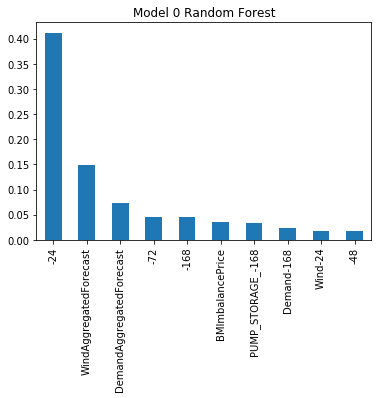

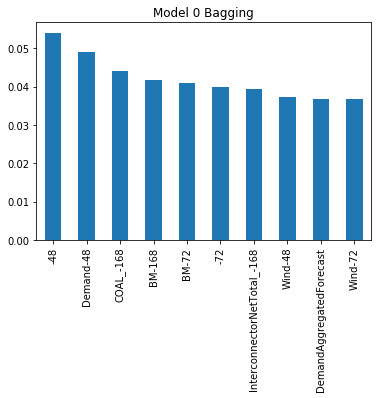

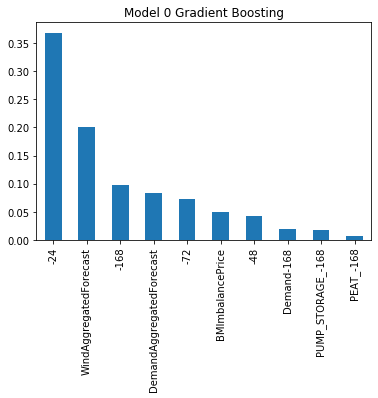

Execution time: 51.79012966156006 seconds


In [9]:
start = time.time()

# Model 0: EURPrices against all other variables (ts1)
model1_importances = get_feature_importance(ts1, n_estimators=[65,65,65], plot=True,
                                            n_plot=10, model_name="Model 0", return_val=True)

print(f"Execution time: {time.time()-start} seconds")

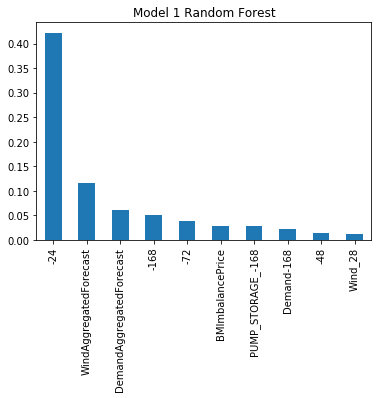

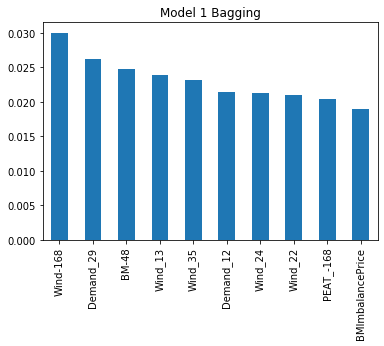

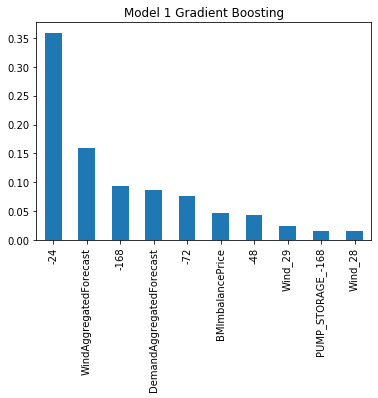

Execution time: 106.73747897148132 seconds


In [10]:
start = time.time()

# Model 1: EURPrices against all other variables (ts2)
model1_importances = get_feature_importance(ts2, n_estimators=[65,65,65], plot=True,
                                            n_plot=10, model_name="Model 1", return_val=True)

print(f"Execution time: {time.time()-start} seconds")

The RF and GB models (top 10 importances plotted above) have the same top 6 features:
* -24 (EURPrices with lag of 24 hours = 1 day)
* -72 (EURPrices with lag of 72 hours = 3 days)
* -168 (EURPrices with lag of 168 hours = 7 days = 1 week) 
* WindAggregatedForecast
* DemandAggregatedForecast
* BMImbalancePrice

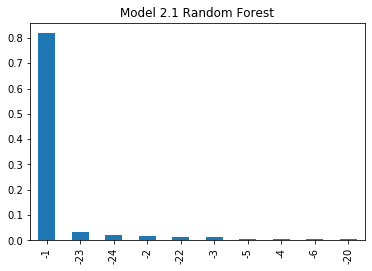

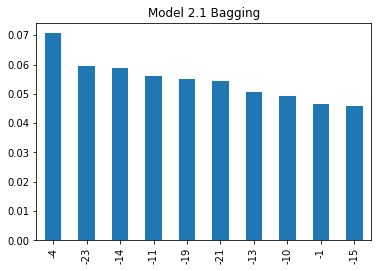

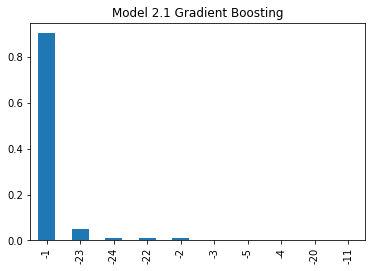

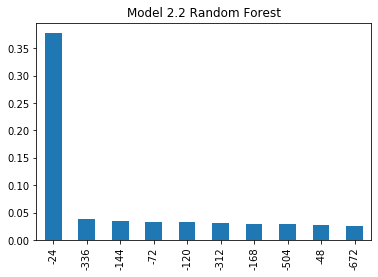

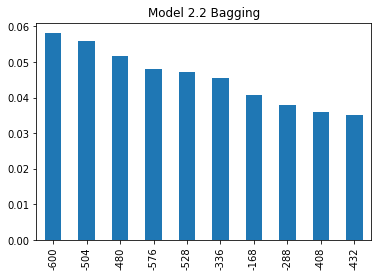

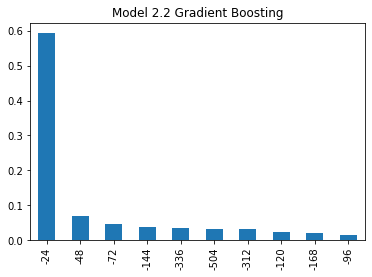

Execution time: 97.89970088005066 seconds


In [11]:
start = time.time()



""" Model 2: EURPrices against (several other) price lags
"""

### Create table of selected price lags as time series.
lags1 = list(range(1,25))           # price lags for the past 24 hours
lags2 = list(range(24, 672+24, 24)) # price lags for the past 4 weeks

# Set up tables with prices
table1 = pd.DataFrame(ts2["EURPrices"])
table2 = pd.DataFrame(ts2["EURPrices"])

# Add designated price lags to each table
for i, lag in enumerate(lags1):
    table1.insert(i+1, str(-lag), table1["EURPrices"].shift(lag))
for j, lag in enumerate(lags2):
    table2.insert(j+1, str(-lag), table2["EURPrices"].shift(lag))

# Remove rows with NAs.
table1 = table1.loc[table1.notna().all(axis=1),:].reset_index(drop=True)
table2 = table2.loc[table2.notna().all(axis=1),:].reset_index(drop=True)
    
    
### Fit models and obtain/plot feature importances    
# Model 2.1
model2_1_importances = get_feature_importance(table1, n_estimators=[65,65,65], plot=True,
                                              n_plot=12, return_val=True, model_name="Model 2.1")
# Model 2.2
model2_2_importances = get_feature_importance(table2, n_estimators=[65,65,65], plot=True,
                                              n_plot=14, return_val=True, model_name="Model 2.2")



print(f"Execution time: {time.time()-start} seconds")

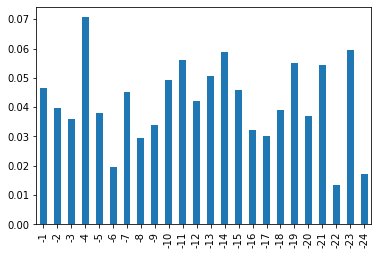

In [12]:
model2_1_importances["Bagging"].plot.bar()#.sort_values(ascending=False).plot.bar()

In [9]:
ts2.columns

Index(['EURPrices', '-24', '-48', '-72', '-168', 'BMImbalancePrice', 'BM-24',
       'BM-48', 'BM-72', 'BM-168', 'WindAggregatedForecast', 'Wind-24',
       'Wind-48', 'Wind-72', 'Wind-168', 'DemandAggregatedForecast',
       'Demand-24', 'Demand-48', 'Demand-72', 'Demand-168', 'MULTI_FUEL_-168',
       'GAS_-168', 'HYDRO_-168', 'PEAT_-168', 'COAL_-168', 'PUMP_STORAGE_-168',
       'BIOMASS_-168', 'OIL_-168', 'DISTILLATE_-168', 'SOLAR_-168',
       'NONE_-168', 'InterconnectorNetTotal_-24',
       'InterconnectorNetTotal_-168', 'Wind_35', 'Wind_34', 'Wind_33',
       'Wind_32', 'Wind_31', 'Wind_30', 'Wind_29', 'Wind_28', 'Wind_27',
       'Wind_26', 'Wind_25', 'Wind_24', 'Wind_23', 'Wind_22', 'Wind_21',
       'Wind_20', 'Wind_19', 'Wind_18', 'Wind_17', 'Wind_16', 'Wind_15',
       'Wind_14', 'Wind_13', 'Wind_12', 'Demand_35', 'Demand_34', 'Demand_33',
       'Demand_32', 'Demand_31', 'Demand_30', 'Demand_29', 'Demand_28',
       'Demand_27', 'Demand_26', 'Demand_25', 'Demand_24', 'Dem

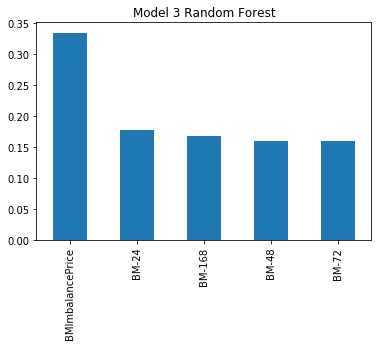

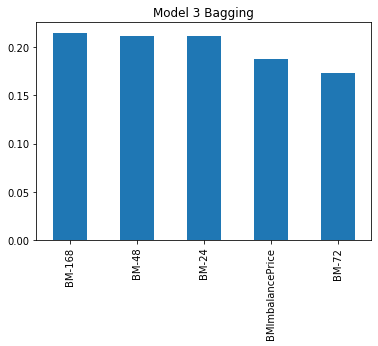

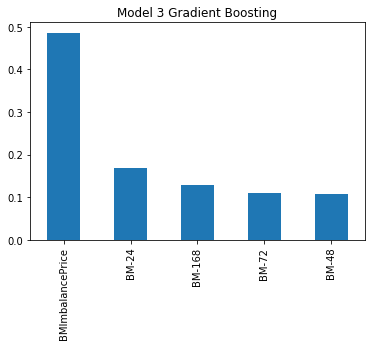

Execution time: 15.487673997879028 seconds


In [13]:
start = time.time()

bm_columns = ["EURPrices","BMImbalancePrice", "BM-24", "BM-48", "BM-72", "BM-168"]
bm_table = ts2[bm_columns]


# Model 3: EURPrices against BM ImbalancePrice and its lags
model1_importances = get_feature_importance(bm_table, n_estimators=[65,65,65], plot=True,
                                            n_plot=10, model_name="Model 3", return_val=True)

print(f"Execution time: {time.time()-start} seconds")

### Feature Selection Ideas:
Check variable importance on:
0. Entire dataset. EURPrices against all the other variables (ts1).
1. Entire dataset. EURPrices against all the other variables (ts2).
2. Only endogenous data, i.e. EURPrices against various lags of EURPrices.
3. EURPrices against BMImbalancePrice and its lags
4. EURPrices against all the hours of WindAggregatedForecast plus wind lags
5. EURPrices against all the hours of DemandAggregatedForecast plus demand lags
6. X-Model specific: Each price class against <b>the other price classes and their lags (up to 168 hours of lags)</b>, <b>day of the week indicator</b> (must add 6 columns [Tuesday, ..., Sunday] of binary data), <b>WindAggregatedForecast</b>, <b>EURPrices</b>, <b>DemandAggregatedForecast</b>, <b>volume</b> (might need some work to set up this data)

For benchmarking, we will also design an implementation to forecast 24 hours ahead. We have designed the implementation in a separate file.

In [59]:
def RandomForest(data, target, y="EURPrices", n_trees=50):
    if "AuctionDateTime" in data.columns:
        data = data.drop("AuctionDateTime", axis=1)
        
    rf_model = ensemble.RandomForestRegressor(n_estimators=n_trees)
    rf_model.fit(X=data, y=data[y])
    
    
    
    # Create and prepare forecasts dataframe
    forecast_df = pd.DataFrame(dict(EURPrices=forecast[0]), columns=["DeliveryDay", "TimeStepID","EURPrices"])
    forecast_df["TimeStepID"] = list(range(24))
    forecast_df["DeliveryDay"] = target
    forecast_df.set_index(["DeliveryDay", "TimeStepID"], inplace=True)

In [60]:
RandomForest(ts1, "")

NameError: name 'X' is not defined